# Classifying Spectral types

## Introduction

Initially, classifying the spectra using ML was more for fun than for a purpose. But on the light of my other notebook on determining the redshifts using ML, classification of spectal types could help reduce the errors on the determining the redshifts using photometry.

The data was obtained using the skyserver from the Sloan Digital Sky Survey (SDSS) using the SQL query. In the SQL query, I specified for no missing values of the redshift or the five bands (u,g,r,i,z). Also the dered values were obtained to account for galactic extinction. For each spectral class (star, galaxy and QSO), 5000 sources were obtained; giving a total of 15000 sources.

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

In [2]:
#loading files
filepath= "/home/veroastro/Documents/spectraTypes/data/"
star = pd.read_csv(filepath+"STAR2_Skyserver_SQL2_12_2022 5_02_48 PM.csv")
QSO = pd.read_csv(filepath+"QSO2Skyserver_SQL2_12_2022 5_03_49 PM.csv")
galaxy = pd.read_csv(filepath+"GALAXY2Skyserver_SQL2_12_2022 5_03_24 PM.csv")
star.head()

,#objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,zWarning,class,subClass
0,1237648703511068760,3,18.77188,0.018979,17.43419,0.004775,16.93682,0.004398,16.76784,0.004519,16.69084,0.009132,334462399065122816,0.000273,0.000010,0.028731,0.012854,0,STAR,F9
1,1237648703511068760,3,18.77188,0.018979,17.43419,0.004775,16.93682,0.004398,16.76784,0.004519,16.69084,0.009132,334463218732787712,0.000268,0.000012,0.028731,0.012854,0,STAR,F9
2,1237650761850290262,3,20.95792,0.113500,18.33668,0.007373,16.96131,0.004531,16.33501,0.004110,15.97918,0.007425,368266889681463296,0.000002,0.000009,0.205829,0.021877,0,STAR,M0
3,1237648705678147694,3,17.76817,0.012322,16.35608,0.003747,15.82515,0.003405,15.65219,0.003503,15.55778,0.005531,409929854226556928,0.000027,0.000007,0.024064,0.008734,0,STAR,F9
4,1237648705130987618,3,19.09714,0.034568,17.45125,0.006773,17.63474,0.006646,24.28417,3.215709,17.99097,0.034200,604619828854024192,-0.000010,0.000010,-9999.000000,-9999.000000,0,STAR,F9


In [3]:
# Concatenating the three dataframes
data = pd.concat([star, QSO, galaxy])
#scrambling the data so that they are not ordered by class
data = data.sample(frac=1)
data.head()

,#objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,zWarning,class,subClass
3596,1237657877538996616,3,18.77780,0.021533,17.14138,0.004635,16.54338,0.004038,16.29598,0.004109,16.26506,0.007232,1043882979413223424,-0.000153,0.000012,0.018998,0.022096,0,STAR,K1
3877,1237655371433115750,3,19.70977,0.041320,19.57509,0.015132,19.08462,0.013293,18.87117,0.016542,18.43765,0.042202,873788251691837440,0.293577,0.000054,0.353059,0.038993,0,QSO,BROADLINE
4485,1237657190905741604,3,20.49796,0.081518,19.93220,0.022153,19.51818,0.021206,19.00519,0.018617,18.70650,0.052173,771257416066033664,0.583773,0.000215,0.439675,0.168145,0,QSO,NaN
84,1237651752923562103,3,17.01539,0.035806,15.42125,0.004727,14.98335,0.004504,14.71907,0.005077,14.56652,0.015886,302956442304931840,0.046220,0.000009,0.029971,0.008899,0,GALAXY,STARFORMING
2415,1237655124465418333,3,23.50389,12.862410,22.23635,2.266559,18.09105,0.081327,16.75460,0.036049,16.21874,0.081100,940188858522298368,0.000076,0.000055,0.304357,0.030680,0,STAR,M5


In [4]:
data.shape

(15000, 20)

In [5]:
cols= ['zWarning','specObjID','#objID']
data_clean = data.drop(columns=['zWarning','specObjID','#objID'])
data_clean.shape

(15000, 17)

In [6]:
data_clean.head()

,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,z,zErr,photoZ,photoErr,class,subClass
3596,3,18.77780,0.021533,17.14138,0.004635,16.54338,0.004038,16.29598,0.004109,16.26506,0.007232,-0.000153,0.000012,0.018998,0.022096,STAR,K1
3877,3,19.70977,0.041320,19.57509,0.015132,19.08462,0.013293,18.87117,0.016542,18.43765,0.042202,0.293577,0.000054,0.353059,0.038993,QSO,BROADLINE
4485,3,20.49796,0.081518,19.93220,0.022153,19.51818,0.021206,19.00519,0.018617,18.70650,0.052173,0.583773,0.000215,0.439675,0.168145,QSO,NaN
84,3,17.01539,0.035806,15.42125,0.004727,14.98335,0.004504,14.71907,0.005077,14.56652,0.015886,0.046220,0.000009,0.029971,0.008899,GALAXY,STARFORMING
2415,3,23.50389,12.862410,22.23635,2.266559,18.09105,0.081327,16.75460,0.036049,16.21874,0.081100,0.000076,0.000055,0.304357,0.030680,STAR,M5


In [7]:
# Encoding to integers the classes
def type_to_value(n):
    if n == 'STAR':
        return 1
    elif n == 'QSO':
        return 2
    elif n == 'GALAXY':
        return 3
    

data_clean['nClass'] = [type_to_value(n) for n in data_clean['class']]

In [8]:
# Removing errors, redshift and class data
data1 = data_clean.drop(['err_u', 'err_g', 'err_r', 'err_i', 'err_z','z', 'zErr', 'class', 'subClass','photoZ','photoErr'], axis = 1)
data1.head()

,type,dered_u,dered_g,dered_r,dered_i,dered_z,nClass
3596,3,18.77780,17.14138,16.54338,16.29598,16.26506,1
3877,3,19.70977,19.57509,19.08462,18.87117,18.43765,2
4485,3,20.49796,19.93220,19.51818,19.00519,18.70650,2
84,3,17.01539,15.42125,14.98335,14.71907,14.56652,3
2415,3,23.50389,22.23635,18.09105,16.75460,16.21874,1


In [9]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

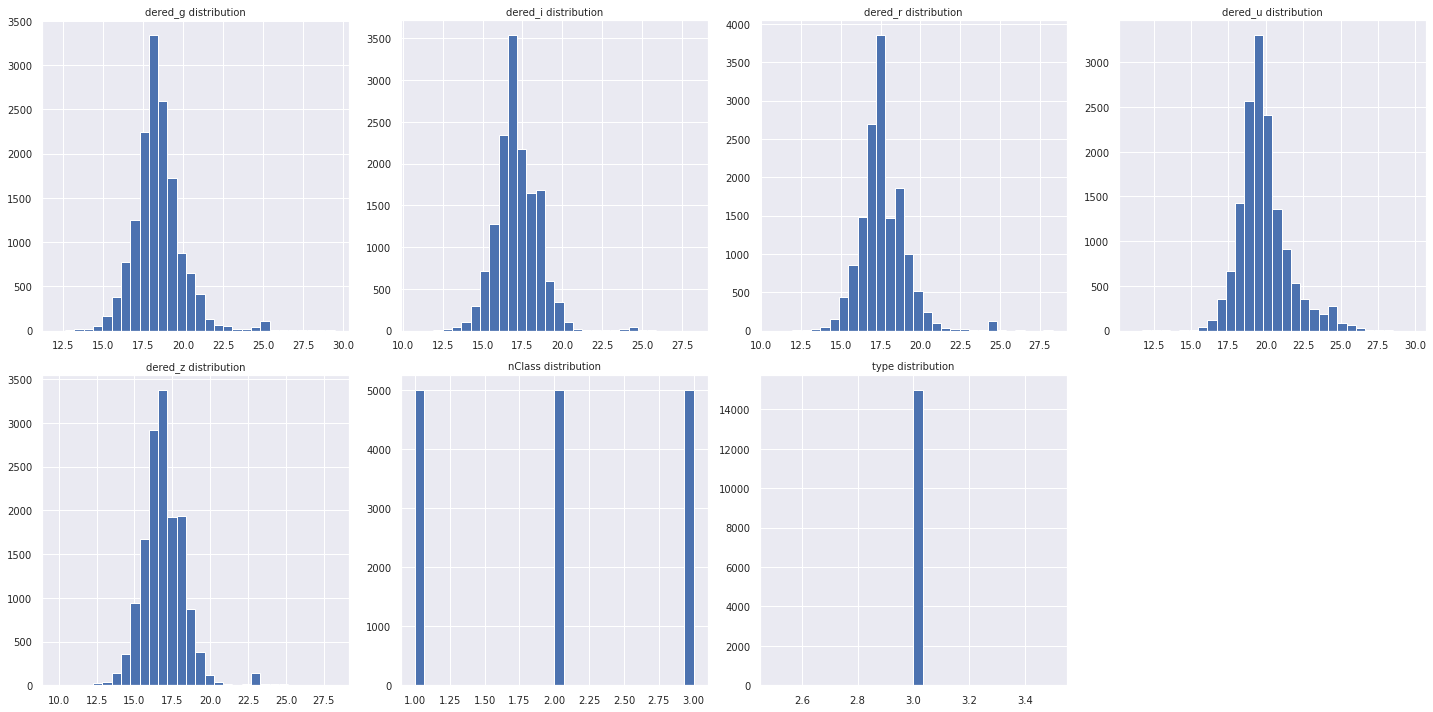

In [10]:
hist_plots(data=data1,
          rows=2,
          cols=4,
          figsize=(20,10))

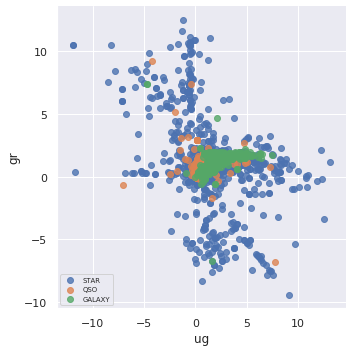

In [11]:
# Calculating colours u-g and g-r
colour = data
colour['ug'] =  data['dered_u'] - data['dered_g']
colour['gr'] =  data['dered_g'] - data['dered_r']

sns.lmplot( x="ug", y="gr", data= colour, fit_reg=False, hue='class', legend=False)
 

plt.legend(fontsize='x-small', loc='lower left')

plt.show()

In [12]:
# Separating the features and the labled data and normalising the data
from sklearn.preprocessing import MinMaxScaler
cols= data1.columns[:-1]
X = data1[cols]
y = data1['nClass']
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X)

In [13]:
# split the data in train and test subsets
from sklearn.model_selection import StratifiedShuffleSplit


# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=3, 
                                          test_size=0.3, 
                                          random_state=42)



train_idx, test_idx = next(strat_shuf_split.split(X_t,y))
print(train_idx.shape)
print(test_idx.shape)

X_train = data1[cols].iloc[train_idx]
y_train = data1['nClass'].iloc[train_idx]
X_test  = data1[cols].iloc[test_idx]
y_test  = data1['nClass'].iloc[test_idx]



(10500,)
(4500,)


In [14]:
#Calculating colours to test importance
X_colour = X

X_colour['ug'] = X_colour['dered_u'] - X_colour['dered_g']
X_colour['gr'] = X_colour['dered_g'] - X_colour['dered_r']
X_colour['ri'] = X_colour['dered_r'] - X_colour['dered_i']
X_colour['iz'] = X_colour['dered_i'] - X_colour['dered_z']
X_colour.head()

,type,dered_u,dered_g,dered_r,dered_i,dered_z,ug,gr,ri,iz
3596,3,18.77780,17.14138,16.54338,16.29598,16.26506,1.63642,0.59800,0.24740,0.03092
3877,3,19.70977,19.57509,19.08462,18.87117,18.43765,0.13468,0.49047,0.21345,0.43352
4485,3,20.49796,19.93220,19.51818,19.00519,18.70650,0.56576,0.41402,0.51299,0.29869
84,3,17.01539,15.42125,14.98335,14.71907,14.56652,1.59414,0.43790,0.26428,0.15255
2415,3,23.50389,22.23635,18.09105,16.75460,16.21874,1.26754,4.14530,1.33645,0.53586


In [15]:
#creating a feature dataset with colours (diference between bands)
X_train_c = X_colour.iloc[train_idx]
X_test_c  = X_colour.iloc[test_idx]


In [16]:
# using logistic regression on the non-colour data

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
params = {"C":np.logspace(-3,3,30), "penalty":["l1","l2"]}


grid = GridSearchCV(LogisticRegression(solver='liblinear'), params)


GR = grid.fit(X_train, y_train)

/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

In [17]:
GR.best_params_ ,GR.best_score_

({'C': 8.531678524172806, 'penalty': 'l1'}, 0.6194285714285714)

In [18]:
y_pred=grid.predict(X_test)
#y_prob=grid.predict_proba(X_test)

In [19]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred)
print(cr)


              precision    recall  f1-score   support

           1       0.57      0.49      0.53      1500
           2       0.71      0.81      0.75      1500
           3       0.54      0.53      0.53      1500

    accuracy                           0.61      4500
   macro avg       0.60      0.61      0.60      4500
weighted avg       0.60      0.61      0.60      4500



Trying adding colours to the dataframe  and redo the algorithm

In [20]:
# test with colours
GR = grid.fit(X_train_c, y_train)
GR.best_params_ ,GR.best_score_

/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

({'C': 1.2689610031679222, 'penalty': 'l1'}, 0.6193333333333333)

In [21]:
y_pred_c=grid.predict(X_test_c)

In [22]:
cr_c = classification_report(y_test, y_pred_c)
print(cr_c)

              precision    recall  f1-score   support

           1       0.57      0.49      0.53      1500
           2       0.71      0.81      0.76      1500
           3       0.54      0.53      0.53      1500

    accuracy                           0.61      4500
   macro avg       0.60      0.61      0.61      4500
weighted avg       0.60      0.61      0.61      4500



 Colour doesn't affect the estimation of the spectral classes

## Testing other classifiers
   ### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators':range(1,400, 40)}


RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)
rf = GridSearchCV(RF,
                  param_grid=param_grid)

rf = rf.fit(X_train, y_train)

/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/veroastro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserW

In [24]:
rf.best_params_ ,rf.best_score_

({'n_estimators': 361}, 0.8925714285714286)

In [25]:
y_pred_rf = rf.predict(X_test)
cr = classification_report(y_test, y_pred_rf)
print(cr)

              precision    recall  f1-score   support

           1       0.91      0.91      0.91      1500
           2       0.95      0.88      0.91      1500
           3       0.85      0.92      0.88      1500

    accuracy                           0.90      4500
   macro avg       0.90      0.90      0.90      4500
weighted avg       0.90      0.90      0.90      4500



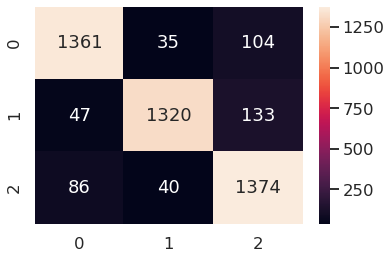

In [26]:
from sklearn.metrics import confusion_matrix
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_rf)
ax = sns.heatmap(cm, annot=True, fmt='d')

### Decision Tree Classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier


param_grid = {'max_depth':range(1, 1000, 40),
              'max_features': [ 'auto', 'sqrt', 'log2']}

GR_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR_dt = GR_dt.fit(X_train, y_train)

In [28]:
#GR_dt.tree_.node_count, GR_dt.tree_.max_depth
GR_dt.best_params_ ,GR_dt.best_score_

({'max_depth': 41, 'max_features': 'auto'}, 0.8254285714285713)

In [29]:

y_pred_dt = GR_dt.predict(X_test)
cr_dt = classification_report(y_test, y_pred_dt)
print(cr_dt)


              precision    recall  f1-score   support

           1       0.85      0.84      0.84      1500
           2       0.86      0.86      0.86      1500
           3       0.81      0.81      0.81      1500

    accuracy                           0.84      4500
   macro avg       0.84      0.84      0.84      4500
weighted avg       0.84      0.84      0.84      4500



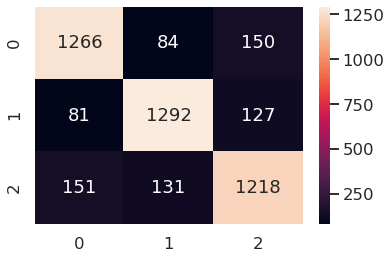

In [30]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_dt)
ax = sns.heatmap(cm, annot=True, fmt='d')

### Gradient Boosting Classifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

tree_list = [15, 25, 50, 100, 200, 400]
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

y_pred_gbc = GV_GBC.predict(X_test)
print(classification_report(y_pred_gbc, y_test))

              precision    recall  f1-score   support

           1       0.86      0.89      0.87      1440
           2       0.85      0.93      0.89      1372
           3       0.90      0.80      0.85      1688

    accuracy                           0.87      4500
   macro avg       0.87      0.87      0.87      4500
weighted avg       0.87      0.87      0.87      4500



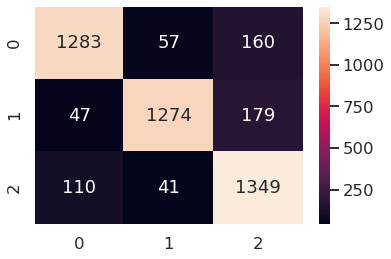

In [32]:

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_gbc)
ax = sns.heatmap(cm, annot=True, fmt='d')

# Conclusion

I obtained 90% accuracy with Random Forest Classifier and over 82% on the other classifiers except Logistic Regression (62%) which was a litle over random in some cases. Colours, as expected from the image (ug vs gr), didn't add any new information to the models. 

This is less than obtained on the Determining Redshift notebook and not good enough to imporove estimation of redshifts.